## Lect 1_Part 1 Simple LPP Problem using PyPSA

### Powerplants: Coal, gas, Timestep:1

In [27]:
import pypsa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Create a new PyPSA network
network = pypsa.Network()
network.set_snapshots(range(1))  # Solve for a single time snapshot

# Define the buses (electricity demand)
network.add("Bus", "electricity_bus", carrier="electricity")

# Add generators (power plants) with defined emissions rate per MWh generated
network.add("Generator", "Coal", bus="electricity_bus", p_nom_extendable=False, marginal_cost=30, p_nom=60, carrier="coal")
network.add("Generator", "Gas", bus="electricity_bus", p_nom_extendable=False, marginal_cost=60, p_nom=80, carrier="gas")

network.madd(
    "Carrier",
    names=["coal","gas"],
    color=["black","darkslategray"],
    co2_emissions=[0.8,0.4],
)

# Add global CO2 emissions constraint for the entire network
network.add(
    "GlobalConstraint",
    "emission_limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=40,  # Total CO2 emissions limit in tons
)

# Add load data (electricity demand)
network.add("Load", "electricity_load", bus="electricity_bus", p_set=70)

# Optimize the network to minimize the total cost
network.optimize(solver_name="highs")

# Print the results
print(network.generators_t.p)  # Power output per generator
print(f"Total Cost of Electricity Generation: {network.objective} €")
print(f"Total CO2 Emissions: {network.global_constraints.constant} tons")
# Individual emissions
emissions_ind = (network.generators_t.p/ network.generators.efficiency* network.generators.carrier.map(network.carriers.co2_emissions))
print(f"Total Emissions: {emissions_ind.sum().sum()} tons")

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.25s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.30e+03


Generator  Coal   Gas
snapshot             
0          30.0  40.0
Total Cost of Electricity Generation: 3300.0 €
Total CO2 Emissions: GlobalConstraint
emission_limit    40.0
Name: constant, dtype: float64 tons
Total Emissions: 40.0 tons


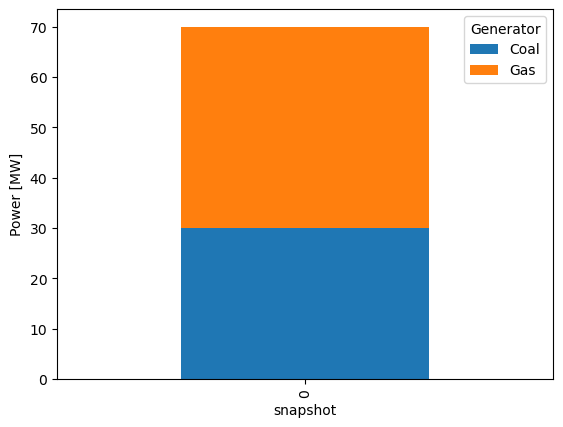

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
network.generators_t.p.plot(kind="bar", stacked=True, ax=ax)
plt.ylabel("Power [MW]")
plt.show()